In [68]:
#!pip install scrapy
#!pip install squarify
#!pip install --upgrade plotly

In [2]:
import scrapy
from scrapy import Selector
from scrapy.http import HtmlResponse
import requests
import pandas as pd
import numpy as np
import string 
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Setting up my favourite style for the plots
sns.set_context('talk')
plt.style.use('fivethirtyeight')

# Web Scraping

I scraped the salaries from https://www.basketball-reference.com/contracts/players.html .
Attention! They are only salaries (no sponsors) before the 20% decrease COVID19 agreement. 

In [4]:
url='https://www.basketball-reference.com/contracts/players.html'
html = requests.get(url).content
sel = Selector(text = html)
player = sel.xpath('//tbody//td[@data-stat="player"]//text()').extract()
salary = sel.xpath('//tbody//td[@data-stat="y1"]//text()').extract()

In [6]:
# Length of players looks OK, salary list is short of 1 player because there is 1 salaries missing from Basketball-reference
len(player), len(salary)

(513, 512)

In [7]:
# Let's checkt the top10 players and salaries
player[:10], salary[:10]

(['Stephen Curry',
  'Russell Westbrook',
  'Chris Paul',
  'John Wall',
  'James Harden',
  'LeBron James',
  'Kevin Durant',
  'Paul George',
  'Klay Thompson',
  'Mike Conley'],
 ['$43,006,362',
  '$41,358,814',
  '$41,358,814',
  '$41,254,920',
  '$40,824,000',
  '$39,219,565',
  '$39,058,950',
  '$35,450,412',
  '$35,361,360',
  '$34,504,132'])

In [8]:
# Remove $ signs
salary = [s.replace('$', '') for s in salary]

In [9]:
# Remove commas
salary = [int(s.replace(',', '')) for s in salary]

In [10]:
# Convert to Euro (7/3/2021)
salary = np.array(salary)*0.84

In [12]:
# Create DataFrame with 480 players. remove a few players from the end
df = pd.DataFrame({
    'player': player[:512],
    'salary': salary[:512]
})

In [13]:
df.head(10)

,player,salary
0,Stephen Curry,36125344.08
1,Russell Westbrook,34741403.76
2,Chris Paul,34741403.76
3,John Wall,34654132.80
4,James Harden,34292160.00
5,LeBron James,32944434.60
6,Kevin Durant,32809518.00
7,Paul George,29778346.08
8,Klay Thompson,29703542.40
9,Mike Conley,28983470.88


In [14]:
df.tail()

,player,salary
507,Didi Louzada,103102.44
508,Troy Williams,98198.52
509,Freddie Gillespie,77999.88
510,Demetrius Jackson,588000.00
511,Chimezie Metu,42000.00


In [16]:
df.info(), df.describe(include = 'all')
# The average salary is 6.6 millions, the median is 3.2 millions. I will use the median because the distribution is skewed.
# The 25% is about 1.6 millions and the 75% is 8.3 millions per year.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   player  512 non-null    object 
 1   salary  512 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.1+ KB


(None,             player        salary
 count          512  5.120000e+02
 unique         490           NaN
 top     Khem Birch           NaN
 freq             2           NaN
 mean           NaN  6.556649e+06
 std            NaN  7.682464e+06
 min            NaN  4.200000e+04
 25%            NaN  1.577971e+06
 50%            NaN  3.198623e+06
 75%            NaN  8.335186e+06
 max            NaN  3.612534e+07)

In [17]:
df.player.value_counts()[:10]
# Some players appear 2 times in the list. I will remove the second time, so that each player appears only once.
# This happens beacause of mid-season trades or trabsfers, e.g. Blake Griffin from the Pistons to the Nets.

Khem Birch           2
Dewayne Dedmon       2
Elfrid Payton        2
Patrick Patterson    2
Chimezie Metu        2
Damian Jones         2
Alex Len             2
DeMarcus Cousins     2
Jeff Teague          2
Jabari Parker        2
Name: player, dtype: int64

In [18]:
# Let's make a list only with the "double" players
double_players = []
for p in range(len(df.player.value_counts() > 1)):
  if (df.player.value_counts() > 1)[p] == True:
    double_players.append((df.player.value_counts() > 1).index[p])

In [19]:
# Let's see who they are
df[df['player'].isin(double_players)]

,player,salary
17,Blake Griffin,28295602.44
31,Andre Drummond,24818901.24
58,LaMarcus Aldridge,16025805.60
69,Gorgui Dieng,14773657.92
136,Nicolas Batum,9750914.04
174,Jabari Parker,5810140.56
217,Elfrid Payton,4838400.00
276,Patrick Patterson,3204405.12
279,Khem Birch,2877388.92
284,Dewayne Dedmon,2895881.52


In [20]:
# Drop the duplicates based on the column "player"
df = df.drop_duplicates(subset=['player'])

In [21]:
df

,player,salary
0,Stephen Curry,36125344.08
1,Russell Westbrook,34741403.76
2,Chris Paul,34741403.76
3,John Wall,34654132.80
4,James Harden,34292160.00
...,...,...
506,Justin Anderson,103367.04
507,Didi Louzada,103102.44
508,Troy Williams,98198.52
509,Freddie Gillespie,77999.88


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f271f994910>]],
      dtype=object)

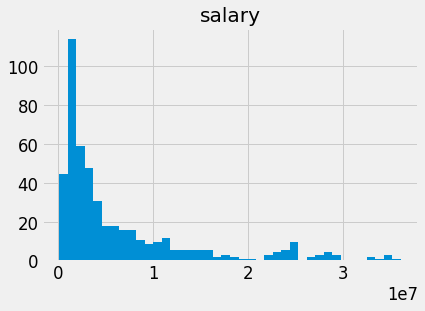

In [22]:
df.hist(bins = 40)
# The majority of the players make less than 5 million per year. A few players reach up to 35 mil/year

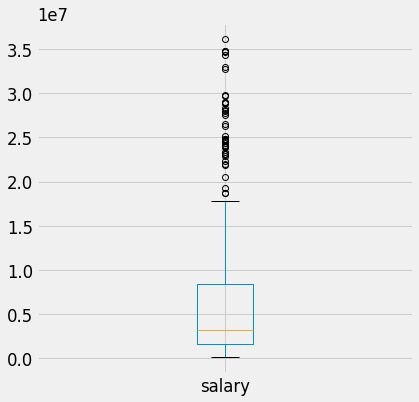

In [23]:
df.boxplot(figsize = (6, 6))
# The median is below 5 mil/year and the "outliers" start at around 18mil/year. These are roughly the top 60 players (18 - 36 mil/year)

In [24]:
len(df[df['salary'] > 24500000])
# Top 30 players have an annual salary of more than 24.5 millions

30

In [25]:
len(df[df['salary'] < 1000000])
# Bottom 45 players have an annual salary of less than 1 million

45

In [26]:
len(df[df['salary'] > np.percentile(df['salary'], 75)])
# 123 players are in the upper quartile

123

In [27]:
len(df[df['salary'] < np.percentile(df['salary'], 25)])
# 123 players are in the lower quartile

123

In [28]:
len(df[(df['salary'] >= np.percentile(df['salary'], 25)) & (df['salary'] <= np.percentile(df['salary'], 75))])
# 244 players are within the interquartile range

244

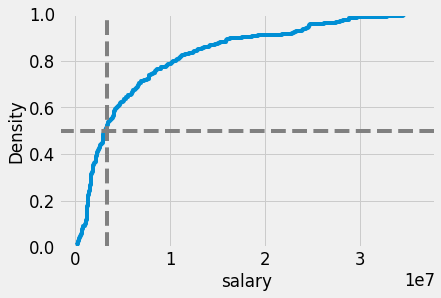

In [29]:
fig, ax = plt.subplots(figsize = (6, 4))
sns.histplot(data = df, x = 'salary', cumulative = True, element = 'step', fill = False, stat = 'density', bins = 400)
ax.set_ylim(0, 1)
plt.axhline(y = 0.5, linestyle = '--', color = 'grey') 
plt.axvline(x = 3360000, linestyle = '--', color = 'grey') 
# Half the NBA players make less that 3.6 mil/year

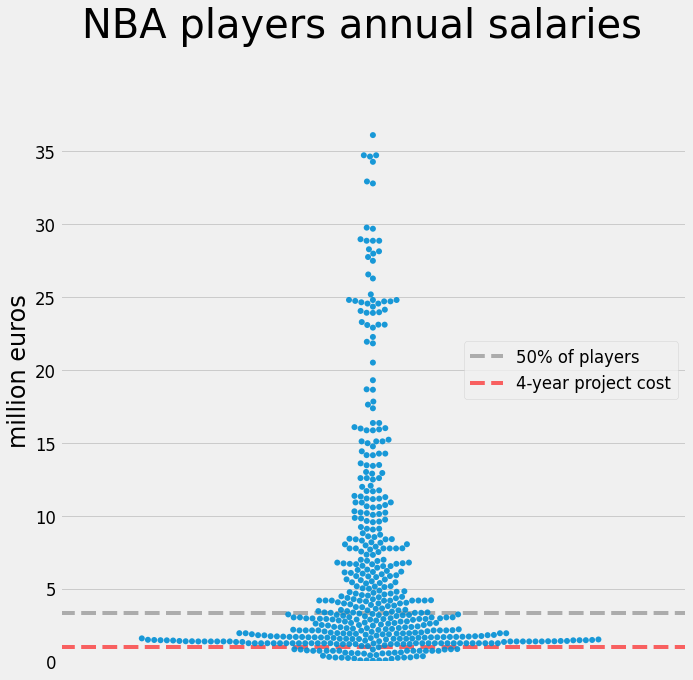

In [45]:
# Let's make a swarmplot of all the salaries. Each dot is one player. The superstars are at the top part, while the bulk of. the players are close to the bottom. The majority of the players 
# take low salaries while a few superstars make a lot of money. There is an order of magnitude difference between players at the bottom, in the middle and at the top of the salary list.
# I will add a grey line showing the middle of the list (median or 50% of players) and a red one, showing the budget for a 4-year scientific project involving several researchers.
fig, ax = plt.subplots(figsize = (10, 10))
sns.swarmplot(data = df, y = 'salary', zorder = 1, size = 6, alpha = 0.9)
fig.suptitle('NBA players annual salaries', fontsize = 40)
ax.set_yticklabels(['0','5','10','15','20','25','30','35'])
plt.ylim(0,40000000)
plt.ylabel('million euros', fontsize=24)
plt.axhline(y = 3370000, color = 'grey', linestyle = '--', label = '50% of players', zorder = 0, alpha = 0.6)
plt.axhline(y = 1000000, color = 'red', linestyle = '--', label = '4-year project cost', zorder = 0, alpha = 0.6)
plt.legend(loc = 5)

# Forbes list

I will scrape the Forbes article with the 10 highest=paid NBA players, including endorsements: https://www.forbes.com/sites/kurtbadenhausen/2021/01/29/the-nbas-highest-paid-players-2021-lebron-curry-durant-score-combined-235-million/

In [46]:
url='https://www.forbes.com/sites/kurtbadenhausen/2021/01/29/the-nbas-highest-paid-players-2021-lebron-curry-durant-score-combined-235-million/'
html = requests.get(url).content
sel = Selector(text = html)
player = sel.xpath('//h3//text()').extract()
salary = sel.xpath('//h2//text()').extract()

In [47]:
# The player list needs cleaning
player

['#10\xa0|\xa0Damian Lillard',
 '#9\xa0|\xa0Chris Paul',
 '#8\xa0|\xa0Kyrie Irving',
 '#7\xa0|\xa0Klay Thompson',
 '#6\xa0|\xa0Giannis Antetokounmpo',
 '#5\xa0|\xa0James Harden',
 '#4\xa0|\xa0Russell Westbrook',
 '#3\xa0|\xa0Kevin Durant',
 '#2\xa0|\xa0Stephen Curry',
 '#1\xa0|\xa0LeBron James']

In [48]:
# The earnings list is messy too
salary[:10]

['Empty arenas will dent NBA salaries 20% this season, but the biggest stars have blockbuster sneaker contracts that keep them among the world’s highest-paid athletes.',
 'Team:',
 '\xa0Portland Trail Blazers',
 'Total Earnings:',
 '\xa0$39 million',
 'Salary:\xa0',
 '$25 million',
 'Endorsements:\xa0',
 '$14 million',
 'Team:']

In [49]:
# Let's remove the weird symbols from the players' names.
player = [p.replace('\xa0|\xa0', '').replace('#', '') for p in player]

In [50]:
# And now get rid of the numbers.
player = [p.translate(str.maketrans('', '', digits)) for p in player]

In [51]:
# Looks much better now
player

['Damian Lillard',
 'Chris Paul',
 'Kyrie Irving',
 'Klay Thompson',
 'Giannis Antetokounmpo',
 'James Harden',
 'Russell Westbrook',
 'Kevin Durant',
 'Stephen Curry',
 'LeBron James']

In [52]:
# Let's select only the elements that start with '\xa0$' and remove the. word 'million'. We will take a clean list with the earnings of each player.
salary = [s[2:].replace(' million', '') for s in salary if s[:2]=='\xa0$'] 

In [53]:
# Let's make a new DataFrame (dforbes) containing only the names and the total earnings (salary + sponsors) of the 10 highest paid players.
dforbes = pd.DataFrame({
    'player' : player,
    'total' : salary
})

In [54]:
# What is the type of the 2 new columns?
dforbes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   player  10 non-null     object
 1   total   10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [55]:
# Let's convert the earnings to numerical and then to euros, by multiplying with 0.84
dforbes['total'] = dforbes['total'].astype('float')
dforbes['total'] = dforbes['total']*0.84

In [56]:
dforbes # Not quite there...

,player,total
0,Damian Lillard,32.760
1,Chris Paul,33.684
2,Kyrie Irving,36.120
3,Klay Thompson,36.372
4,Giannis Antetokounmpo,41.160
5,James Harden,42.000
6,Russell Westbrook,48.804
7,Kevin Durant,54.768
8,Stephen Curry,62.496
9,LeBron James,80.136


In [57]:
# Let's reverse the DataFrame index
dforbes.index = range(len(dforbes)-1, -1, -1)

In [58]:
# And sort the index...
dforbes = dforbes.sort_index()

In [59]:
# Perfect!
dforbes

,player,total
0,LeBron James,80.136
1,Stephen Curry,62.496
2,Kevin Durant,54.768
3,Russell Westbrook,48.804
4,James Harden,42.000
5,Giannis Antetokounmpo,41.160
6,Klay Thompson,36.372
7,Kyrie Irving,36.120
8,Chris Paul,33.684
9,Damian Lillard,32.760


In [60]:
# That's a lot of money!
dforbes.describe()

,total
count,10.000000
mean,46.830000
std,15.172913
min,32.760000
25%,36.183000
50%,41.580000
75%,53.277000
max,80.136000


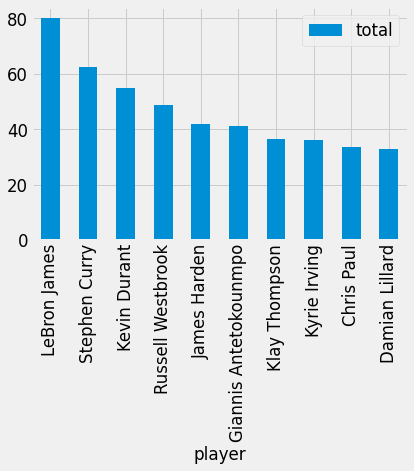

In [61]:
# The top 10 players make between 32 and 80 million euro/year
dforbes.plot(kind='bar', x='player')

In [62]:
# Let's add a row with the cost of a 4-year scientific project involving multiple researchers.
dforbes = dforbes.append(pd.DataFrame({
    'player' : '4-year project',
    'total' : [1]
}, index = [10]))

In [63]:
# And plot a cool Plotly treemap to compare visually the numbers.
# The scientific project is the pink stripe at the bottom, which is barely visible.
fig = px.treemap(dforbes, path = [dforbes['player']], 
                 values='total',
                 color='player',
                 title = "Top 10 NBA players' total annual income"
                )

fig.update_layout(
    width = 800,
    height = 800,
    paper_bgcolor="LightSteelBlue",
    font=dict(size=30),
    title = dict(font_size = 35, y = 0.97),
    margin=dict(l=5, r=5, t=5, b=5)
)

fig.show()

# Big science projects
Let's compare now the sum of all the NBA contracts for 1 year with the costs of some famous, big science projects/constructions.

In [64]:
# I'm making a new DataFrame 
df10 = pd.DataFrame({
    'total' : [df['salary'].sum()/1000000, 4700, (494*0.84), (90*0.84), (1321*0.84)], 
    'name' : ['All players', 'CERN', 'Very large array', '10 seed vaults', 'Juno']})

In [65]:
df10

,total,name
0,3222.819835,All players
1,4700.000000,CERN
2,414.960000,Very large array
3,75.600000,10 seed vaults
4,1109.640000,Juno


In [66]:
# Sort the DataFrame
df10 = df10.sort_values(by=['total'], ascending=False)

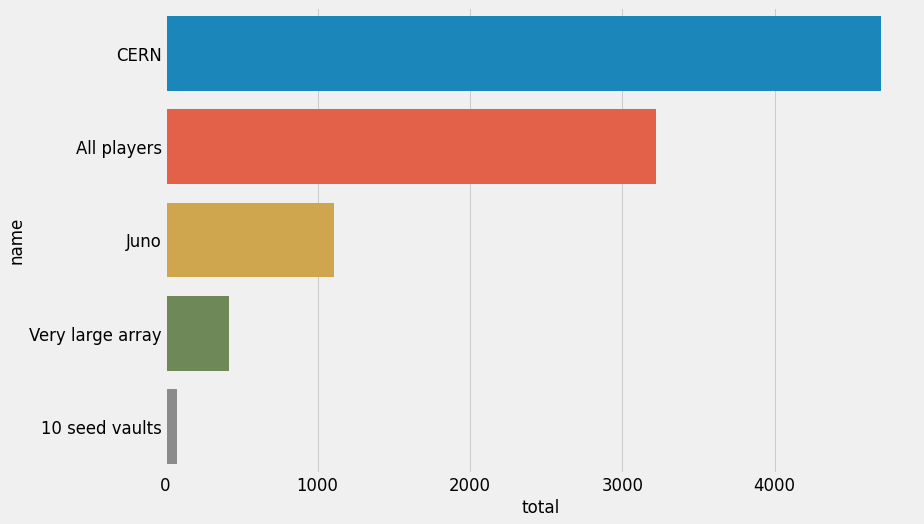

In [67]:
# And make a simple barplot. I think it's enough in this case.
plt.figure(figsize=(12,8))
sns.barplot(data=df10, y='name', x='total')

http://www.swarthmore.edu/Humanities/pschmid1/array/vla.html

https://www.croptrust.org/our-work/svalbard-global-seed-vault/faq-about-the-vault/

https://home.cern/resources/faqs/facts-and-figures-about-lhc

https://www.in2013dollars.com/us/inflation/1972?amount=78578000

https://www.forbes.com/sites/alexknapp/2012/07/05/how-much-does-it-cost-to-find-a-higgs-boson/?sh=464ab0ab3948

https://www.jpl.nasa.gov/news/press_kits/juno/facts/

